In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os

/home/jcthompson5@ad.wisc.edu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# range of L1 penalties to try 
lmbdas = [0., 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.]
len(lmbdas)

10

In [3]:
# import file names
files = os.listdir("data/SET3_Thirdtrial/")
files

['CDanc_CDmono12h_PROVIDET0.csv', 'CDevo_CDmono12h_PROVIDET0.csv']

In [4]:
exp_names = []
# for file in files:
file = files[1]
    
# define strain name
strain = file.split("_")[0]
strain

'CDevo'

In [5]:
# evaluate prediction performance at each lmbda
prediction_performance = np.zeros([len(lmbdas), 10])
for lmbda_idx, lmbda in enumerate(lmbdas):

    # loop over trials
    performances = []
    for trial in range(10):
    
        # import measured and predicted values
        pred_df = []
        test_df = []
        for i in range(20):
            pred_df.append(pd.read_csv(f"Sulaiman_HOI_kfold/{strain}_preds/{strain}_pred_{i}_{lmbda}_{trial}.csv"))
            test_df.append(pd.read_csv(f"Sulaiman_HOI_kfold/folds_{strain}/test_{i}_{trial}.csv"))
        pred_df = pd.concat(pred_df)
        test_df = pd.concat(test_df)

        # species 
        species = test_df.columns.values[2:]

        # eval prediction performance for each species
        r_vals = []
        rmse_vals = []

        for s in species:

            measured_vals = []
            predicted_vals = []

            for t, df_t in test_df.groupby("Treatments"):

                # get predictions for sample
                pred_df_t = pred_df.iloc[np.in1d(pred_df.Treatments.values, t)].copy()

                # true values
                measured_val = df_t[s].values

                # if species was inocuated
                if measured_val[0] > 0:

                    measured_vals.append(measured_val[1:])
                    predicted_vals.append(pred_df_t[s].values[1:])

            measured_vals = np.concatenate(measured_vals)
            predicted_vals = np.concatenate(predicted_vals)

            r_vals.append(pearsonr(measured_vals, predicted_vals)[0])
            rmse_vals.append(np.sqrt(np.mean((measured_vals-predicted_vals)**2)))
        
        # trial performance is average rmse over species
        performances.append(np.mean(r_vals))
        
    # save average prediction performance for species
    prediction_performance[lmbda_idx] = performances

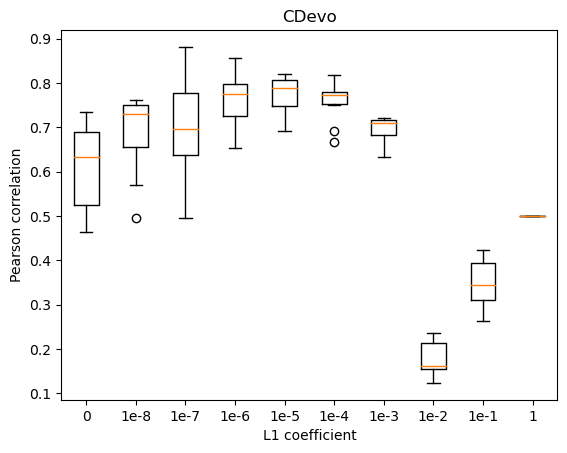

In [6]:
# Create boxplot
fig, ax = plt.subplots()
ax.boxplot(prediction_performance.T)  # Transpose so that each model's evaluations are plotted in separate box

# Set axis labels and title
ax.set_xlabel('L1 coefficient')
ax.set_ylabel('Pearson correlation')
ax.set_title(strain)

# Customize x-axis tick labels
ax.set_xticks(range(1, len(lmbdas) + 1))
ax.set_xticklabels(['0', '1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '1e-2', '1e-1', '1'])

plt.savefig(f"figures/{strain}_performance_vs_L1.pdf")
plt.show()

In [7]:
# save parameters over trials, [trials, lmbdas, params]
params = np.zeros([10, 10, 240])

# import parameters from each trial
for trial in range(10):
    
    # import params
    param_df = pd.read_csv(f"L1scan/{strain}_params_{trial}.csv")
    
    # loop over lmbdas
    for lmbda_idx, lmbda in enumerate(lmbdas):
        
        # store parameters
        params[trial, lmbda_idx] = param_df[f'{lmbda}'].values

In [8]:
# set of HOI params
hoi_params = params[:, :, (8 + 8 ** 2):]
hoi_params.shape

(10, 10, 168)

In [9]:
# index of top 10 HOI parameters at optimal lmbda
lmbda_idx = lmbdas.index(1e-5)

In [10]:
sig_hoi_idx = np.argsort(np.abs(np.mean(hoi_params[:, lmbda_idx], 0)))[-10:]

In [11]:
param_df

,parameter,0.0,1e-08,1e-07,1e-06,1e-05,0.0001,0.001,0.01,0.1,1.0
0,CA,-0.150525,-0.754944,0.208997,0.171903,0.173427,0.311465,0.152692,0.000120,-0.000067,-0.000400
1,BT,0.928076,1.000188,1.002758,0.925553,0.937410,1.038354,1.031654,0.737404,-0.000093,0.000097
2,BU,0.853831,0.929463,0.940946,0.933847,0.922969,0.940737,0.877033,0.628202,0.000137,0.000115
3,CD,0.667632,0.657502,0.669968,0.655201,0.686477,0.638935,0.565035,0.000184,0.000158,0.000047
4,BV,0.675223,0.696519,0.731448,0.729791,0.710320,0.708035,0.660286,0.000353,-0.000009,-0.000158
...,...,...,...,...,...,...,...,...,...,...,...
235,CH<-[CD*CS],0.051066,0.402883,-3.186777,-2.993114,0.001249,0.000099,0.000274,-0.000057,0.000061,-0.000089
236,CH<-[CD*DP],-0.470583,-2.754592,1.974574,3.318638,0.021784,0.000123,-0.000024,0.000132,-0.000012,0.000076
237,CH<-[BV*CS],2.095138,2.429600,4.443632,3.970453,1.193115,-0.000029,-0.000002,-0.000003,0.000117,0.000231
238,CH<-[BV*DP],-3.231788,2.754554,-3.710882,-3.614185,-2.307697,-0.017546,-0.000060,-0.000064,0.000009,-0.000154


In [12]:
hoi_param_names = param_df.parameter.values[72:]

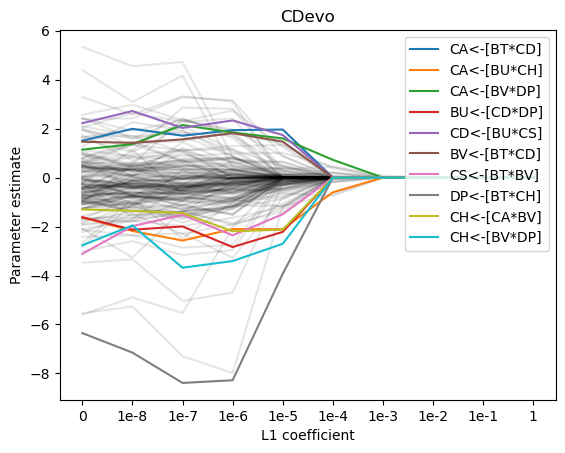

In [13]:

# Create boxplot
fig, ax = plt.subplots()

for hoi_idx in range(hoi_params.shape[-1]):
    
    if hoi_idx in sig_hoi_idx:
        ax.plot(np.mean(hoi_params[:, :, hoi_idx], 0), alpha=1., zorder=1, label=hoi_param_names[hoi_idx])
    else:
        ax.plot(np.mean(hoi_params[:, :, hoi_idx], 0), c='k', alpha=.1, zorder=0)

# add legend
ax.legend(loc='upper right')
        
# Set axis labels and title
ax.set_xlabel('L1 coefficient')
ax.set_ylabel('Parameter estimate')
ax.set_title(strain)

# Customize x-axis tick labels
ax.set_xticks(range(len(lmbdas)))
ax.set_xticklabels(['0', '1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '1e-2', '1e-1', '1'])
plt.savefig(f"figures/{strain}_estimate_vs_l1.pdf")
plt.show()